<h1 align="center" style="font-size: 40px;color: blue;">Data Preprocessing Steps</h1>

## 1. Import Essential Libraries

In [102]:
import numpy as np                    # for data cleaning and stacking od 2d and 3d array of images 
import matplotlib.pyplot as plt       # for data visualization
import pywt                           # for wavelet transformation of the images 
import os                             # to iterate through all the directories where the images are placed
import shutil                         # for removing the unnecessary files and the directories unnecessary
import seaborn as sns                 # for data visualization
import cv2                            # For image preprocessing (read, grayscale, face/eye detection, filtering valid images for the model)

## 2. Data Exploration

In [2]:
# read the image
image = cv2.imread("./Celebrity/Lionel Messi/Lionel_Messi_20180626.jpg")
print(image)

[[[174 149  99]
  [170 145  95]
  [171 144  94]
  ...
  [ 86  76  69]
  [ 87  77  70]
  [ 88  78  71]]

 [[173 146  96]
  [173 146  96]
  [170 143  93]
  ...
  [ 84  74  67]
  [ 85  75  68]
  [ 86  76  69]]

 [[173 146  96]
  [173 146  96]
  [169 142  92]
  ...
  [ 86  76  69]
  [ 84  74  67]
  [ 84  74  67]]

 ...

 [[  1   4   2]
  [  2   5   3]
  [  2   5   3]
  ...
  [  8  10  10]
  [  4   9   8]
  [  3   8   7]]

 [[  2   5   3]
  [  2   5   3]
  [  3   6   4]
  ...
  [  6   6   6]
  [  2   4   4]
  [  1   3   3]]

 [[  2   5   3]
  [  2   5   3]
  [  3   6   4]
  ...
  [  6   6   6]
  [  4   4   4]
  [  3   3   3]]]


In [3]:
# shape of the image  ( length ,width , RGB) 3d
image.shape

(1000, 701, 3)

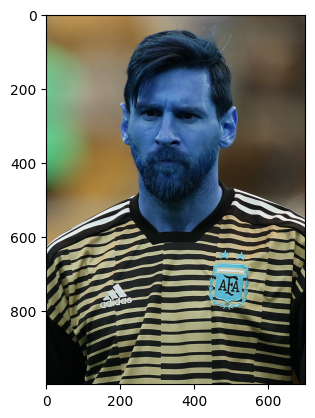

In [4]:
# visualize the image how it looks like
plt.imshow(image)

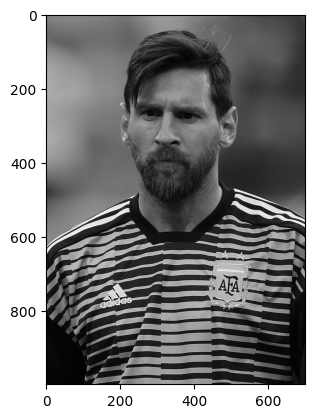

In [5]:
# convert image into a gray scale because model works well on grayscale images as compared to rgbs
gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
plt.imshow(gray , cmap = 'gray')

In [6]:
# Essentail Pre Defined har cascades models to detect the faces and the eyes
face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')

In [7]:
# Detect faces in the grayscale image (returns list of bounding boxes: x, y, w, h)
face = face_cascade.detectMultiScale(gray , 1.3 , 5)

In [8]:
# storing the list into diferent variables
x , y , w , h = face[0] # face[0] because it returns more that 1 list items if the image contain more than one face
x , y , w , h

(np.int32(189), np.int32(164), np.int32(282), np.int32(282))

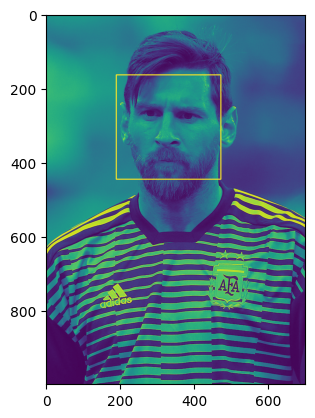

In [9]:
# drawing rectangle boundaries  along the edges of the faces in red color
face_img = cv2.rectangle(gray, (x,y) , (x+w , y+h) , (255 , 0 , 0) , 2)
plt.imshow(face_img)

In [10]:
cv2.destroyAllWindows()

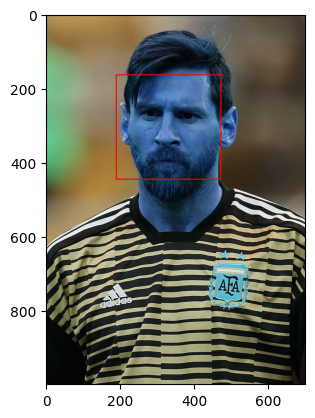

In [11]:
# in this we are extracting the face from that image and face extracted must have 2 eyes ( side pose picture get filtered)
# Extract Face dimensions are stores in roi_color
for x , y , w , h in face:
    face_img = cv2.rectangle(image, (x,y) , (x+w , y+h) , (255 , 0 , 0) , 2)
    roi_gray = gray[y:y+h , x:x+w]
    roi_color = face_img[y:y+h , x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    for (ea , eb , ec , ed) in eyes:
        cv2.rectangle(roi_color, (ea,eb) ,(ea+ec , eb+ed) , (0 , 255 , 0), 2)
plt.figure()
plt.imshow(face_img, cmap='gray')
plt.show()

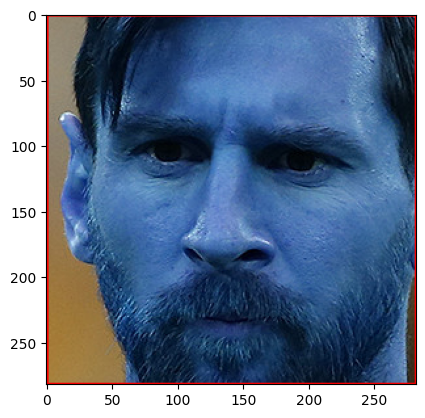

In [12]:
# show the extracted face
plt.imshow(roi_color , cmap = 'gray')

In [13]:
# as we have to extract the faces of all the data so we made a function that take image path and return roi_color ( faces with 2 eyes)
def get_cropped_face(path):
    image = cv2.imread(path)
    gray = cv2.cvtColor(image , cv2.COLOR_BGR2GRAY)
    face_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_frontalface_default.xml')
    eye_cascade = cv2.CascadeClassifier(cv2.data.haarcascades + 'haarcascade_eye.xml')
    faces = face_cascade.detectMultiScale(gray , 1.2 , 5)
    for (x , y , w , h) in faces:
        roi_gray = gray[y:y+h , x:x+w]
        roi_color = image[y:y+h , x:x+w]
        eyes = eye_cascade.detectMultiScale(roi_gray)
        if len(eyes) >= 2:
            return roi_color

(115, 115, 3)

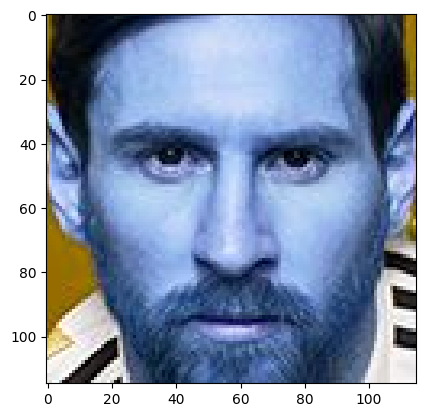

In [14]:
# Same steps but through function this time
cropped_image = get_cropped_face("./Celebrity/Lionel Messi/DdaglCTVQAEtWO4.jpg")
plt.imshow(cropped_image , cmap = 'gray')
cropped_image.shape

In [15]:
# path to data where images are stored and the path where i need to store my cropped faces images
path_to_image = './Celebrity/'
path_to_cropped_images = './Celebrity/cropped/'

In [16]:
# all the image directories first i will store it will be useful later
img_dirs = []
for entry in os.scandir(path_to_image):
    if entry.is_dir():
        img_dirs.append(entry.path)

In [17]:
img_dirs

['./Celebrity/Lionel Messi',
 './Celebrity/Maria Sharapova',
 './Celebrity/Roger Federer',
 './Celebrity/Serena Williams',
 './Celebrity/Virat Kohli']

In [18]:
# we first create the cropped directory if not exist
if os.path.exists(path_to_cropped_images):
     shutil.rmtree(path_to_cropped_images)
os.mkdir(path_to_cropped_images)

In [19]:
# in this block , we iterate through all the images in the img_dirs directory
# we create the directories of cropped images of each celebrity
# inside each celebrity directory we store their extracted cropped face images
# side wise we store the path of cropped dirs in the cropped_img_dirs
# also we store the path of image along with te celebrity name in the form of dictionary so that it will be useful later on

cropped_image_dirs = []
celebrity_names = {}
for img_dir in img_dirs:
    
    count = 1                                              # count is  just for the sake that images name are stored as virat kohli1 , virat kohli2 for ease
    celebrity_name = img_dir.split('/')[-1]                # get the celebrity name
    celebrity_names[celebrity_name] = []
    
    for entry in os.scandir(img_dir):                      #iterate through all the images inside the directory line by line
        roi_color = get_cropped_face(entry.path)            # get the cropped faces
        if roi_color is not None:
            cropped_folder = path_to_cropped_images + celebrity_name# cropped folder path
            if not os.path.exists(cropped_folder):
                os.makedirs(cropped_folder)                 # create folder with the celebrity name
                cropped_image_dirs.append(cropped_folder)
                print(f"Generating cropped images in the folder : {cropped_folder}")
            cropped_file_name = celebrity_name + str(count) + '.png' 
            cropped_file_path = cropped_folder + "/" + cropped_file_name
           
            cv2.imwrite(cropped_file_path, roi_color)      # download the cropped images and stored in the cropped folder
            celebrity_names[celebrity_name].append(cropped_file_path)
            count += 1        

Generating cropped images in the folder : ./Celebrity/cropped/Lionel Messi
Generating cropped images in the folder : ./Celebrity/cropped/Maria Sharapova
Generating cropped images in the folder : ./Celebrity/cropped/Roger Federer
Generating cropped images in the folder : ./Celebrity/cropped/Serena Williams
Generating cropped images in the folder : ./Celebrity/cropped/Virat Kohli


In [20]:
cropped_image_dirs

['./Celebrity/cropped/Lionel Messi',
 './Celebrity/cropped/Maria Sharapova',
 './Celebrity/cropped/Roger Federer',
 './Celebrity/cropped/Serena Williams',
 './Celebrity/cropped/Virat Kohli']

In [21]:
celebrity_names

{'Lionel Messi': ['./Celebrity/cropped/Lionel Messi/Lionel Messi1.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi2.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi3.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi4.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi5.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi6.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi7.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi8.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi9.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi10.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi11.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi12.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi13.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi14.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi15.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi16.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi17.png',
  './Celebrity/cropped/L

In [157]:
# wavelet transformation taht will tranform the raw image into the harimage and returns 2d representation id wavelet transformed image
# it captures frequency ( edges wrinkles etc)
def w2d(img, mode='haar', level=1):
    imArray = img
    #Datatype conversions
    #convert to grayscale
    imArray = cv2.cvtColor( imArray,cv2.COLOR_RGB2GRAY )
    #convert to float
    imArray =  np.float32(imArray)   
    imArray /= 255;
    # compute coefficients 
    coeffs=pywt.wavedec2(imArray, mode, level=level)

    #Process Coefficients
    coeffs_H=list(coeffs)  
    coeffs_H[0] *= 0;  

    # reconstruction
    imArray_H=pywt.waverec2(coeffs_H, mode);
    imArray_H *= 255;
    imArray_H =  np.uint8(imArray_H)

    return imArray_H

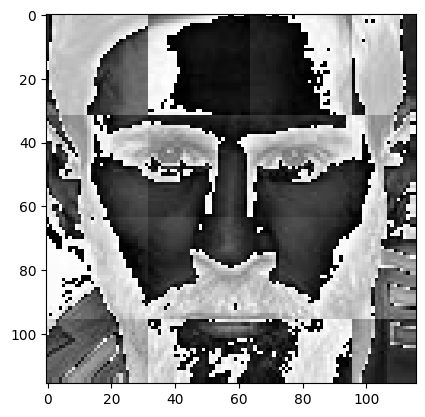

In [23]:
# Wavelet Transformed Image 
im_har = w2d(cropped_image,'db1',5)
plt.imshow(im_har, cmap='gray')

In [24]:
# wavelet transfored imaeg array
im_har

array([[ 43,   8, 218, ...,  45,  41,  41],
       [ 44,   6, 216, ...,  44,  38,  38],
       [ 42,   2, 212, ...,  43,  32,  32],
       ...,
       [ 92,  95,  91, ...,  46,  46,  46],
       [ 96,  77, 110, ...,  51,  50,  50],
       [ 96,  77, 110, ...,  51,  50,  50]], shape=(116, 116), dtype=uint8)

In [25]:
# dimenstions of har image 2D
im_har.shape

(116, 116)

In [26]:
# dimensions of the cropped face image 3D
cropped_image.shape

(115, 115, 3)

In [27]:
# Map target celebroity names categorical data into numerical data because model works only on numerical data
class_dict = {}
count = 0
for celebrity_name in celebrity_names.keys():
    class_dict[celebrity_name] = count
    count = count + 1
class_dict

{'Lionel Messi': 0,
 'Maria Sharapova': 1,
 'Roger Federer': 2,
 'Serena Williams': 3,
 'Virat Kohli': 4}

## 3. Manual Data Cleaning of Images ( blurr  , side pose , unwanted) 

## 4. Dictionary recreating as we delete some file during manual cleaning

In [110]:
# update celebrity_names dictionary
root_dir = "./Celebrity/cropped"
celebrity_names = {}

for celeb_name in os.listdir(root_dir):
    celeb_folder = os.path.join(root_dir, celeb_name)
    
    if os.path.isdir(celeb_folder):
        image_files = [
            os.path.join(celeb_folder, img).replace("\\", "/")  # ✅ force forward slashes
            for img in os.listdir(celeb_folder)
            if img.lower().endswith(('.png', '.jpg', '.jpeg'))
        ]
        
        image_files.sort()
        celebrity_names[celeb_name] = image_files

In [203]:
celebrity_names

{'Lionel Messi': ['./Celebrity/cropped/Lionel Messi/Lionel Messi10.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi11.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi13.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi14.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi15.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi16.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi17.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi18.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi19.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi2.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi20.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi23.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi24.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi25.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi27.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi28.png',
  './Celebrity/cropped/Lionel Messi/Lionel Messi30.png',
  './Celebrity/c

<h1 align="center" style="font-size: 40px;color: blue;">Feature Extraction</h1>

In [204]:
# Extract features now from the images using raw + har image
Features, Target = [], []

for celebrity_name, images in celebrity_names.items():
    for image in images:
        raw_image = cv2.imread(image)
        if raw_image is None:
            continue  # skip if image not found
        
        # Resize original face
        scaled_raw_image = cv2.resize(raw_image, (32, 32))
        
        # Wavelet transformed image
        har_image = w2d(raw_image, 'db1', 5)   # <-- w2d should return grayscale wavelet image
        scaled_har_image = cv2.resize(har_image, (32, 32))
        
        # Flatten both
        raw_flat = scaled_raw_image.reshape(-1, 1)   # 3072 × 1
        har_flat = scaled_har_image.reshape(-1, 1)   # 1024 × 1
        
        # Stack vertically → shape (4096, 1)
        combined_image = np.vstack((raw_flat, har_flat))
        
        # Convert to 1D feature vector
        feature_vector = combined_image.flatten()
        
        # Append to dataset
        Features.append(feature_vector)
        Target.append(class_dict[celebrity_name])

# Convert to numpy arrays
Features = np.array(Features)
Target = np.array(Target)

print("Feature shape:", Features.shape)   # (num_samples, 4096)
print("Target shape:", Target.shape)     # (num_samples,)

Feature shape: (154, 4096)
Target shape: (154,)


In [205]:
len(Features)

154

In [206]:
len(Target)

154

In [207]:
len(Features[0])

4096

In [208]:
Features.shape

(154, 4096)

<h1 align="center" style="font-size: 40px; color: blue;">Model Training</h1>

## 1. Import Necessary Modules

In [210]:
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV

## 2. Feature Scaling

In [213]:
# During training
scaler = StandardScaler()
X_Scaled = scaler.fit_transform(Features)

## 3. Save the Scaler

In [214]:
import pickle

with open("scaler.pkl", "wb") as f:
    pickle.dump(scaler, f)

## 4. Hyper Parameter Tuning

In [212]:
# Algorithms and their hyperparameter grids
algorithms = {
    'SVC': {
        'model': SVC(),
        'params': {
            'C': [0.1, 1, 10],
            'kernel': ['linear', 'rbf'],
            'gamma': ['scale', 'auto']
        }
    },
    'RandomForest': {
        'model': RandomForestClassifier(),
        'params': {
            'n_estimators': [50, 100, 200],
            'max_depth': [None, 5, 10],
            'min_samples_split': [2, 5],
            'min_samples_leaf': [1, 2]
        }
    },
    'KNN': {
        'model': KNeighborsClassifier(),
        'params': {
            'n_neighbors': [3, 5, 7],
            'weights': ['uniform', 'distance'],
            'metric': ['euclidean', 'manhattan']
        }
    }
}

## By Hyper Parameter Tuning SVC is the Best Algorithm for this model

In [202]:
from sklearn.model_selection import GridSearchCV

best_models = {}

for algo_name, config in algorithms.items():
    print(f"Running GridSearchCV for {algo_name}...")
    grid = GridSearchCV(estimator=config['model'],
                        param_grid=config['params'],
                        cv=5, n_jobs=-1, verbose=1)
    grid.fit(X_Scaled, Target)
    best_models[algo_name] = {
        'best_estimator': grid.best_estimator_,
        'best_score': grid.best_score_,
        'best_params': grid.best_params_
    }

# Check results
for name, result in best_models.items():
    print(f"\n{name}:")
    print("Best Score:", result['best_score'])
    print("Best Params:", result['best_params'])

Running GridSearchCV for SVC...
Fitting 5 folds for each of 12 candidates, totalling 60 fits
Running GridSearchCV for RandomForest...
Fitting 5 folds for each of 36 candidates, totalling 180 fits
Running GridSearchCV for KNN...
Fitting 5 folds for each of 12 candidates, totalling 60 fits

SVC:
Best Score: 0.8963440860215053
Best Params: {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}

RandomForest:
Best Score: 0.8703225806451613
Best Params: {'max_depth': 10, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 200}

KNN:
Best Score: 0.7726881720430108
Best Params: {'metric': 'manhattan', 'n_neighbors': 5, 'weights': 'distance'}


## 5. Split into train test sample

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(
    X_Scaled, Target,             # your features and target
    test_size=0.2,    # fraction of data to keep for testing (e.g., 20%)
    train_size=0.8,   # fraction for training (optional, usually inferred)
    random_state=42,  # seed for reproducibility
    shuffle=True,     # whether to shuffle before splitting (default=True)
    stratify=Target        # keep class distribution same in train/test (useful for classification)
)

## 6. Train the Model using the default parameters

In [215]:
model = SVC()
model.fit(X_train , y_train)

,C,1.0
,kernel,'rbf'
,degree,3
,gamma,'scale'
,coef0,0.0
,shrinking,True
,probability,False
,tol,0.001
,cache_size,200
,class_weight,None
,verbose,False


## 7. Accuracy Check of the Model

In [216]:
model.score(X_test , y_test)

0.9032258064516129

<h1 align="center" style="font-size: 40px; color: blue;">Model Evaluation</h1>

## 1. Import Necessary Modules

In [219]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix

## 2. Get confusion Matrix

In [221]:
y_predicted = model.predict(X_test)
cm = confusion_matrix(y_test , y_predicted)
cm

array([[6, 0, 0, 0, 0],
       [0, 6, 0, 0, 0],
       [1, 0, 5, 0, 0],
       [0, 0, 1, 3, 1],
       [0, 0, 0, 0, 8]])

## 3. Draw Confusion Matrix to get more clear visuals

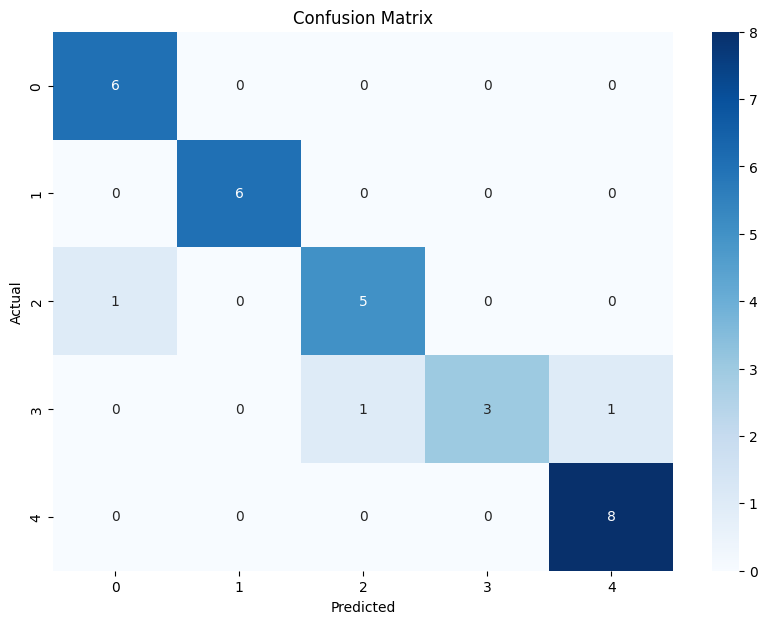

In [223]:
plt.figure(figsize=(10, 7))  # <-- 'figsize' not 'fig_size'
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')  # fmt='d' for integers
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

<h1 align="center" style="font-size: 40px; color: blue;">Store Model using Joblib</h1>

In [225]:
import joblib

In [226]:
joblib.dump(model , 'Celebrity Image.pkl')

['Celebrity Image.pkl']

<h1 align="center" style="font-size: 40px; color: blue;">Make Predictions using raw image</h1>

## Load the model and scaler

In [237]:
# Load scaler and model
import pickle
import joblib
with open("scaler.pkl", "rb") as f:
    scaler = pickle.load(f)
svcmodel = joblib.load('Celebrity Image.pkl')

## Specify the flow how features are extracted from the image in order to make prediction

In [239]:
import cv2
import numpy as np
import CroppedFaces as cf
import WaveletTransformation as wt  # your w2d

# Function to extract features from one image
def features(image_path):
    image = cf.get_cropped_face(image_path)  # cropped face image
    if image is None:
        return None  # no face detected
    
    # Resize original face
    scaled_raw_image = cv2.resize(image, (32, 32))
    
    # Wavelet transformed image
    har_image = wt.w2d(image, 'db1', 5)
    scaled_har_image = cv2.resize(har_image, (32, 32))
    
    # Flatten both
    raw_flat = scaled_raw_image.reshape(-1, 1)   # 3072 × 1
    har_flat = scaled_har_image.reshape(-1, 1)   # 1024 × 1
    
    # Stack vertically → shape (4096, 1)
    combined_image = np.vstack((raw_flat, har_flat))
    
    return combined_image.flatten()


# Wrapper for prediction
def real_features(image_path, scaler):
    feature = features(image_path)
    if feature is None:
        return None  # no face detected
    
    feature = np.array(feature).reshape(1, -1)
    feature = scaler.transform(feature)  # use the scaler you fitted on training set
    return feature

## mapping predictions to names

In [245]:
celebrities = {
    0: 'Lionel Messi',
    1: 'Serena Williams',
    2: 'Maria Sharapova',
    3: 'Roger Federer',
    4: 'Virat Kohli'
}

## Now Finally Make Prediction

In [246]:
def predict_celebrity(image_path, model, scaler, class_dict):
    features = real_features(image_path, scaler)
    pred = model.predict(features)[0]  # directly pick the first element
    return class_dict[pred]

In [247]:
print("Celebrity Predicted by the Model is :", 
      predict_celebrity(r'C:\Users\M Sajid\Desktop\ML Project\Celebrity\Virat Kohli\9e30af3e8d.jpg', svcmodel, scaler, celebrities))

Celebrity Predicted by the Model is : Virat Kohli


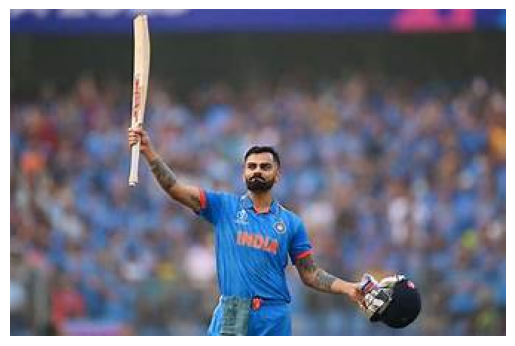

In [249]:
import cv2
import numpy as np
import urllib.request
import matplotlib.pyplot as plt

url = "https://tse3.mm.bing.net/th/id/OIP.VwUIxemJi5aTGBAatvD57AHaE4?pid=Api&P=0&h=220"

# Read the image from the URL into a byte array
resp = urllib.request.urlopen(url)
image_data = np.asarray(bytearray(resp.read()), dtype="uint8")

# Decode the image (OpenCV format)
im = cv2.imdecode(image_data, cv2.IMREAD_COLOR)

# Convert BGR → RGB for matplotlib
im = cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

plt.imshow(im)
plt.axis("off")
plt.show()

In [253]:
import requests

url = "http://127.0.0.1:5000/predict"
data = {"image_path": r"C:\Users\M Sajid\Desktop\ML Project\Test Data\Virat Kohli.jpeg"}

response = requests.post(url, json=data)
print(response.json())

{'error': 'No image provided'}
